# Clasificación de Texto

Paso 1: Importar Librerías

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

#para preprocesamiento de texto
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

In [3]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Paso 2: Carga de datos y EDA (Exploratory Data Analysis)

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
df=pd.read_csv('2021_tweets.csv')
print(df.shape)
df.head()

Exploratory Data Analysis (EDA)

1.- Distribución de las clases

In [ ]:
vc=df['Sentiment'].value_counts()
print(vc)
sns.barplot(x=vc.index, y=vc.values)

Nos quedamos solo con los positivos y negativos

In [ ]:
df = df[(df['Sentiment'] == 'positivo') | (df['Sentiment'] == 'negativo')]
df.head()

In [ ]:
vc=df['Sentiment'].value_counts()
print(vc)
sns.barplot(x=vc.index, y=vc.values)

Tomemos una muestra aleatoria de 5 mil datos de cada clase

Vamos a "balancear" las clases dejando la misma cantidad de elementos de la clase positivo y de la clase negativo

In [10]:
df_positivo = df[df['Sentiment'] == 'positivo']
df_positivo = df_positivo.sample(5000)

In [11]:
df_negativo = df[df['Sentiment'] == 'negativo']
df_negativo = df_negativo.sample(5000)

In [12]:
df = pd.concat([df_positivo, df_negativo])

In [ ]:
vc=df['Sentiment'].value_counts()
print(vc)
sns.barplot(x=vc.index, y=vc.values)

2. Datos faltantes

In [ ]:
df.isna().sum()

In [15]:
df = df.dropna()

Agregamos la columna de Clase en donde los positivos son 1 y los negativos son 0

In [ ]:
from sklearn.preprocessing import LabelEncoder
y=df.loc[:,'Sentiment'] #Todas las filas de la columna Sentiment
transmission_encoder = LabelEncoder() #Se crea un codificador
y = transmission_encoder.fit_transform(y) #Se ajusta el codificador
y

In [ ]:
df['Clase'] = y
df.head()

3.- Cantidad de palabras, caracteres y palabras únicas en textos de cada una de las clases

In [ ]:
#1. CANTIDAD DE PALABRAS
df['cantidad_de_palabras'] = df['Text'].apply(lambda x: len(str(x).split()))
print('Palabras en tweets Positivos',df[df['Clase']==1]['cantidad_de_palabras'].mean()) #textos positivos
print('Palabras en tweets Negativos', df[df['Clase']==0]['cantidad_de_palabras'].mean()) #textos negativos


#2. CANTIDAD DE CARACTERES
df['cantidad_de_caracteres'] = df['Text'].apply(lambda x: len(str(x)))
print('Caracteres en tweets Positivos', df[df['Clase']==1]['cantidad_de_caracteres'].mean()) #textos positivos
print('Caracteres en tweets Negativos', df[df['Clase']==0]['cantidad_de_caracteres'].mean()) #textos negativos


#3. CANTIDAD DE PALABRAS ÚNICAS
df['cantidad_de_palabras_unicas'] = df['Text'].apply(lambda x: len(set(str(x).split())))
print('Palabras únicas en tweets Positivos', df[df['Clase']==1]['cantidad_de_palabras_unicas'].mean()) #textos positivos
print('Palabras únicas en tweets Negativos', df[df['Clase']==0]['cantidad_de_palabras_unicas'].mean()) #textos negativos

In [ ]:
df.head()

Observamos la distribución con base en la cantidad de palabras

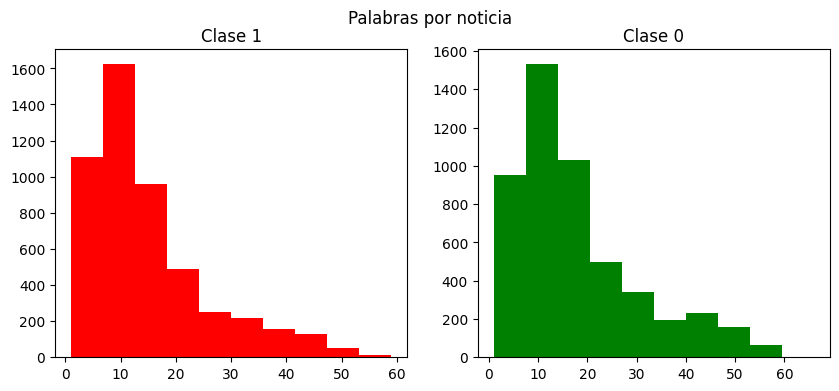

In [23]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
positivos=df[df['Clase']==1]['cantidad_de_palabras']
ax1.hist(positivos,color='red')
ax1.set_title('Clase 1')
negativos=df[df['Clase']==0]['cantidad_de_palabras']
ax2.hist(negativos,color='green')
ax2.set_title('Clase 0')
fig.suptitle('Palabras por noticia')
plt.show()

Paso 3.- PRE-PROCESAMIENTO

## Función para el preprocesamiento

In [24]:
def preprocess(text):
    text = text.lower() #convierte a minúsculas todo el texto
    text=text.strip()  #elimina los espacios en blanco al inicio y al final del texto incluyendo tabuladores y saltos de línea
    text=re.compile('<.*?>').sub('', text) #Elimina las etiquetas de HTML que estén dentro del texto
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  #Reemplaza los signos de puntuación con espacios es blanco
    text = re.sub(r'\d',' ',text) #Elimina todos los dígitos del texto
    text = re.sub('\s+', ' ', text)  #Elimina los espacios extra y tabuladores en el texto
    return text

## Función para eliminar las stopwords

In [25]:
#Eliminar las stopwords
def stopword(text):
    a = [i for i in text.split() if i not in stopwords.words('spanish')]
    return ' '.join(a)

## Preprocesamiento final

In [26]:
def finalpreprocess(text):
  return stopword(preprocess(text))

## Recorrer el dataframe para limpiar cada uno de los textos

In [27]:
df['texto_limpio'] = df['Text'].apply(lambda x: finalpreprocess(x))
df=df.drop(columns=['cantidad_de_palabras','cantidad_de_caracteres','cantidad_de_palabras_unicas'])

## Ver el resultado

In [ ]:
df.head()

In [ ]:
df['Clase'].unique()

Convertimos los textos en vectores con WordToVec

In [30]:
import gensim
from gensim.models import Word2Vec #Word2Vec se utiliza mayormente para conjuntos grandes de datos
import numpy as np

In [31]:
#Para convertir los textos a vectores es necesario separar cada texto en palabras o tokens
df['texto_tokenizado']=[nltk.word_tokenize(i) for i in df['texto_limpio']]
model = Word2Vec(df['texto_tokenizado'],min_count=1)  #min_count=1 significa que cada palabra debe estar al menos una vez en todos los textos,
#si min_count=2 significa que si la palabra está presente menos de dos veces en todos los textos no se debe considerar


w2v = dict(zip(model.wv.index_to_key, model.wv))  #convertir cada palabra a su correspondiente vector


class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(next(iter(word2vec.values())))

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

Vemos que por cada palabra se genera un vector numérico

In [ ]:
w2v

In [36]:
len(w2v['cfemx'])

100

In [37]:
len(w2v['lic'])

100

División entre datos de entrenamiento y datos de prueba con textos etiquetados

In [38]:
from sklearn.model_selection import train_test_split

In [39]:
X_train, X_val, y_train, y_val = train_test_split(df["texto_limpio"],
                                                  df["Clase"],
                                                  test_size=0.2,
                                                  shuffle=True)
X_train_tok= [nltk.word_tokenize(i) for i in X_train]  #para word2vec
X_val_tok= [nltk.word_tokenize(i) for i in X_val]      #para word2vec

In [ ]:
X_train

In [ ]:
y_train

In [ ]:
X_train_tok

In [44]:
#Word2vec
# Fit y transform
modelw = MeanEmbeddingVectorizer(w2v)
X_train_vectors_w2v = modelw.transform(X_train_tok)
X_val_vectors_w2v = modelw.transform(X_val_tok)

In [ ]:
X_train_vectors_w2v

Creación del modelo de regresión logística (LR)

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
#from sklearn.metrics import roc_curve, auc, roc_auc_score

In [ ]:
#AJUSTANDO EL MODELO DE CLASIFICACIÓN UTILIZANDO REGRESIÓN LOGÍSTICA Y WORDTOVEC (w2v)
#lr_w2v=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_w2v=LogisticRegression(solver = 'newton-cg', C=1.0, penalty = 'l2') #se crea el modelo de regresión logística
lr_w2v.fit(X_train_vectors_w2v, y_train)  #se entrena el modelo de regresión logística

#Se predicen los valores del dataset de prueba
y_predict = lr_w2v.predict(X_val_vectors_w2v)
y_prob = lr_w2v.predict_proba(X_val_vectors_w2v)[:,1]

#Se genera la matriz de confusión
print(classification_report(y_val,y_predict))
print('Confusion Matrix:',confusion_matrix(y_val, y_predict))

In [ ]:
y_predict.tolist()
y_prob.tolist()

In [ ]:
len(y_predict)

In [ ]:
columns = ['texto', 'Clase', 'Probabilidad']
df_r = pd.DataFrame(columns = columns)
df_r.head()

In [ ]:
len(X_val)

In [52]:
df_r['texto'] = X_val
df_r['Clase'] = y_predict
df_r['Probabilidad'] = y_prob

In [ ]:
df_r.head()

In [ ]:
cm = confusion_matrix(y_val, y_predict)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

Probando con datos no etiquetados

In [56]:
from google.colab import files
uploaded = files.upload()

Saving 2021_tweets_sin_etiqueta.csv to 2021_tweets_sin_etiqueta.csv


In [57]:
df_test=pd.read_csv('2021_tweets_sin_etiqueta.csv') #Son los tweets sin etiqueta
df_test.head()

,Sentiment,Text
0,negativo,Los daba por muertos 🐻🤩 https://t.co/qNam6Svu3X
1,neutro,@PilarCamachoG La batería tardaba un par de ho...
2,positivo,@gar_mau Estoy esperando que llegues a Merilan...
3,neutro,Tenemos también una exfoliación en cara con pr...
4,positivo,"@leda_vino Gracias Leda, aquí ando de renegado..."


In [58]:
df_test.dropna()
len(df_test)

1001

In [60]:
df_test['texto_limpio'] = df_test['Text'].apply(lambda x: finalpreprocess(x)) #preprocesamiento de los datos
X_test=df_test['texto_limpio']
X_vector=modelw.transform(X_test) #converting X_test en vector
y_predict = lr_w2v.predict(X_vector)      #Utilizar el modelo entrenado
y_prob = lr_w2v.predict_proba(X_vector)[:,1]
df_test['predict_prob']= y_prob
df_test['Clase']= y_predict
df_test.head()

,Sentiment,Text,texto_limpio,predict_prob,Clase
0,negativo,Los daba por muertos 🐻🤩 https://t.co/qNam6Svu3X,daba muertos 🐻🤩 https t co qnam svu x,0.646292,1
1,neutro,@PilarCamachoG La batería tardaba un par de ho...,pilarcamachog batería tardaba par horas llevar...,0.506179,1
2,positivo,@gar_mau Estoy esperando que llegues a Merilan...,gar mau esperando llegues meriland vernos segu...,0.476196,0
3,neutro,Tenemos también una exfoliación en cara con pr...,exfoliación cara precios accesibles puede ser ...,0.472435,0
4,positivo,"@leda_vino Gracias Leda, aquí ando de renegado...",leda vino gracias leda aquí ando renegado siem...,0.493484,0


In [61]:
final=df_test[['Text','Clase']].reset_index(drop=True)
final.to_csv('lr_w2v.csv')

Probemos con otro vectorizador y otro modelo

In [62]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [63]:
#TF-IDF
#Convertir x_train a un vector numérico dado que el modelo solo funciona con números no con palabras
tfidf_vectorizer = TfidfVectorizer(use_idf=True) #Se crea el vectorizador
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) #tfidf funciona con textos no tokenizados en comparación con word2vec
X_val_vectors_tfidf = tfidf_vectorizer.transform(X_val)

Creamos un modelo de Naïve Bayes

In [64]:
from sklearn.naive_bayes import MultinomialNB

In [65]:
nb_tfidf = MultinomialNB() #Se crea el modelo
nb_tfidf.fit(X_train_vectors_tfidf, y_train)  #Se entrena el modelo

#Se utiliza el modelo para predecir con los valores de prueba y se obtienen sus probabilidades
y_predict = nb_tfidf.predict(X_val_vectors_tfidf)
y_prob = nb_tfidf.predict_proba(X_val_vectors_tfidf)[:,1]

#Se imprime la matriz de confusión
print(classification_report(y_val,y_predict))
print('Confusion Matrix:',confusion_matrix(y_val, y_predict))

              precision    recall  f1-score   support

           0       0.80      0.85      0.82       996
           1       0.84      0.79      0.81      1004

    accuracy                           0.82      2000
   macro avg       0.82      0.82      0.82      2000
weighted avg       0.82      0.82      0.82      2000

Confusion Matrix: [[846 150]
 [212 792]]


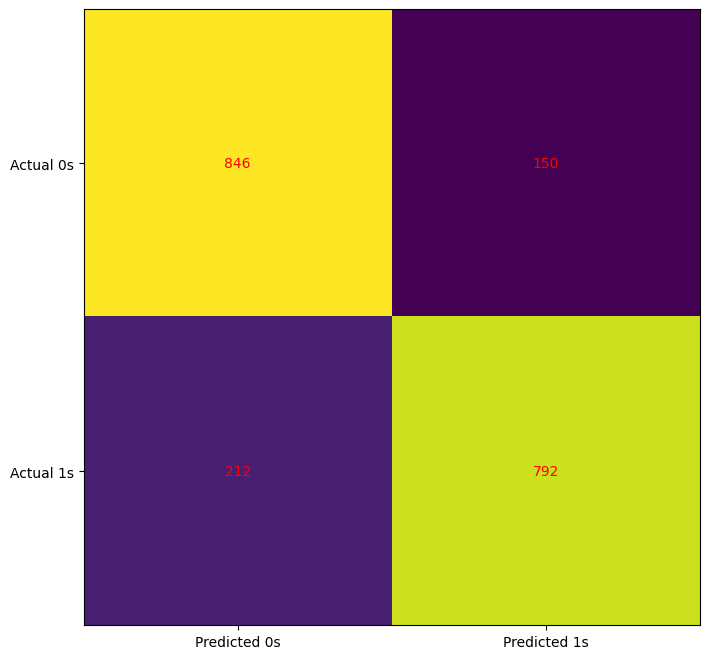

In [66]:
#Se dibuja la matriz de confusión
cm = confusion_matrix(y_val, y_predict)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

In [67]:
df_test['texto_limpio'] = df_test['Text'].apply(lambda x: finalpreprocess(x)) #preprocesamiento de los datos
X_test=df_test['texto_limpio']
X_vector=tfidf_vectorizer.transform(X_test) #convertir X_test en vector
y_predict = nb_tfidf.predict(X_vector)      #usar el modelo entrenado con los datos vectorizados
y_prob = nb_tfidf.predict_proba(X_vector)[:,1]
df_test['predict_prob']= y_prob
df_test['Clase']= y_predict
df_test.head()

,Sentiment,Text,texto_limpio,predict_prob,Clase
0,negativo,Los daba por muertos 🐻🤩 https://t.co/qNam6Svu3X,daba muertos 🐻🤩 https t co qnam svu x,0.445925,0
1,neutro,@PilarCamachoG La batería tardaba un par de ho...,pilarcamachog batería tardaba par horas llevar...,0.359671,0
2,positivo,@gar_mau Estoy esperando que llegues a Merilan...,gar mau esperando llegues meriland vernos segu...,0.403401,0
3,neutro,Tenemos también una exfoliación en cara con pr...,exfoliación cara precios accesibles puede ser ...,0.245351,0
4,positivo,"@leda_vino Gracias Leda, aquí ando de renegado...",leda vino gracias leda aquí ando renegado siem...,0.537486,1


In [68]:
final=df_test[['Text','Clase']].reset_index(drop=True)
final.to_csv('NB_TFIDF.csv')